In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import rasterio
from PIL import Image
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from scipy.ndimage import rotate
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

C:\Users\Computec\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
class AdvancedImageTransform:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, image):
        image = image.astype(np.float32).copy()
        
        # Random rotation (90 degrees only)
        if np.random.rand() < self.p:
            k = np.random.randint(0, 4)
            image = np.rot90(image, k=k).copy()
        
        # Random flip
        if np.random.rand() < self.p:
            image = np.flip(image, axis=1).copy()
        
        return image

In [3]:
class WaterSegmentationDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.tif')])
        self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.png')])
        self.matched_files = self.match_images_and_labels()
    
    def match_images_and_labels(self):
        matched_files = []
        image_names = {os.path.splitext(f)[0] for f in self.image_files}
        label_names = {os.path.splitext(f)[0] for f in self.label_files}
        common_names = image_names.intersection(label_names)
        
        for name in common_names:
            matched_files.append((f"{name}.tif", f"{name}.png"))
        
        print(f"Matched {len(matched_files)} image-label pairs")
        return matched_files
    
    def _load_multispectral_image(self, image_path):
        try:
            with rasterio.open(image_path) as src:
                image = src.read()
                image = image.transpose(1, 2, 0)
            image = cv2.resize(image, (256, 256))
            image = self._normalize_image(image)
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return np.zeros((256, 256, 12), dtype=np.float32)
    
    def _normalize_image(self, image):
        normalized_image = np.zeros_like(image, dtype=np.float32)
        for i in range(image.shape[2]):
            channel = image[:,:,i]
            mean = channel.mean()
            std = channel.std()
            normalized_image[:,:,i] = (channel - mean) / (std + 1e-7)
        return normalized_image
    
    def _load_label(self, label_path):
        try:
            label = Image.open(label_path).convert('L')
            label = np.array(label)
            label = cv2.resize(label, (256, 256))
            label = (label > 0).astype(np.float32)
            return label
        except Exception as e:
            print(f"Error loading label {label_path}: {e}")
            return np.zeros((256, 256), dtype=np.float32)
    
    def __getitem__(self, idx):
        image_file, label_file = self.matched_files[idx]
        image = self._load_multispectral_image(os.path.join(self.images_dir, image_file))
        label = self._load_label(os.path.join(self.labels_dir, label_file))
        
        if self.transform:
            image = self.transform(image)
        
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        
        return image, label
    
    def __len__(self):
        return len(self.matched_files)

In [4]:
class EnhancedAttentionUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(EnhancedAttentionUNet, self).__init__()
        
        # Initial convolution
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Bridge
        self.bridge = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3)
        )
        
        # Decoder
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Initial convolution
        x = self.init_conv(x)
        
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        
        # Bridge
        bridge = self.bridge(self.pool2(enc2))
        
        # Decoder
        dec2 = self.upconv2(bridge)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final_conv(dec1)

In [5]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
    
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return 0.5 * bce_loss + 0.5 * dice_loss

In [6]:
def calculate_metrics(pred, target):
    pred_binary = (pred > 0.5).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    iou = intersection / (union + 1e-7)
    precision = intersection / (pred_binary.sum() + 1e-7)
    recall = intersection / (target_binary.sum() + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    return {
        'IoU': iou.item(),
        'Precision': precision.item(),
        'Recall': recall.item(),
        'F1 Score': f1.item()
    }

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=200, device='cuda', patience=15):
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_metrics': [], 'val_metrics': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_metrics = {'IoU': 0, 'Precision': 0, 'Recall': 0, 'F1 Score': 0}
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            optimizer.step()
            
            train_loss += loss.item()
            metrics = calculate_metrics(outputs, masks)
            for k, v in metrics.items():
                train_metrics[k] += v
        
        train_loss /= len(train_loader)
        for k in train_metrics:
            train_metrics[k] /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_metrics = {'IoU': 0, 'Precision': 0, 'Recall': 0, 'F1 Score': 0}
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                metrics = calculate_metrics(outputs, masks)
                for k, v in metrics.items():
                    val_metrics[k] += v
        
        val_loss /= len(val_loader)
        for k in val_metrics:
            val_metrics[k] /= len(val_loader)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print('Train Metrics:', train_metrics)
        print('Val Metrics:', val_metrics)
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.2e}')
        print('-' * 50)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
    
    return history

Using device: cpu
Matched 306 image-label pairs
Epoch [1/200]
Train Loss: 0.5547, Val Loss: 0.6786
Train Metrics: {'IoU': 0.3897982571394213, 'Precision': 0.5106575277543837, 'Recall': 0.6457172834104107, 'F1 Score': 0.5500932460831057}
Val Metrics: {'IoU': 0.2825966142117977, 'Precision': 0.29731350392103195, 'Recall': 0.8157806992530823, 'F1 Score': 0.434037446975708}
Learning Rate: 5.00e-04
--------------------------------------------------
Epoch [2/200]
Train Loss: 0.5140, Val Loss: 0.5854
Train Metrics: {'IoU': 0.433630149210653, 'Precision': 0.5590394021522614, 'Recall': 0.6775063084017846, 'F1 Score': 0.5941614455753758}
Val Metrics: {'IoU': 0.3538926988840103, 'Precision': 0.4246748089790344, 'Recall': 0.6768259257078171, 'F1 Score': 0.5208099111914635}
Learning Rate: 5.00e-04
--------------------------------------------------
Epoch [3/200]
Train Loss: 0.5054, Val Loss: 0.5714
Train Metrics: {'IoU': 0.436294830854862, 'Precision': 0.570636604822451, 'Recall': 0.6749174373765146

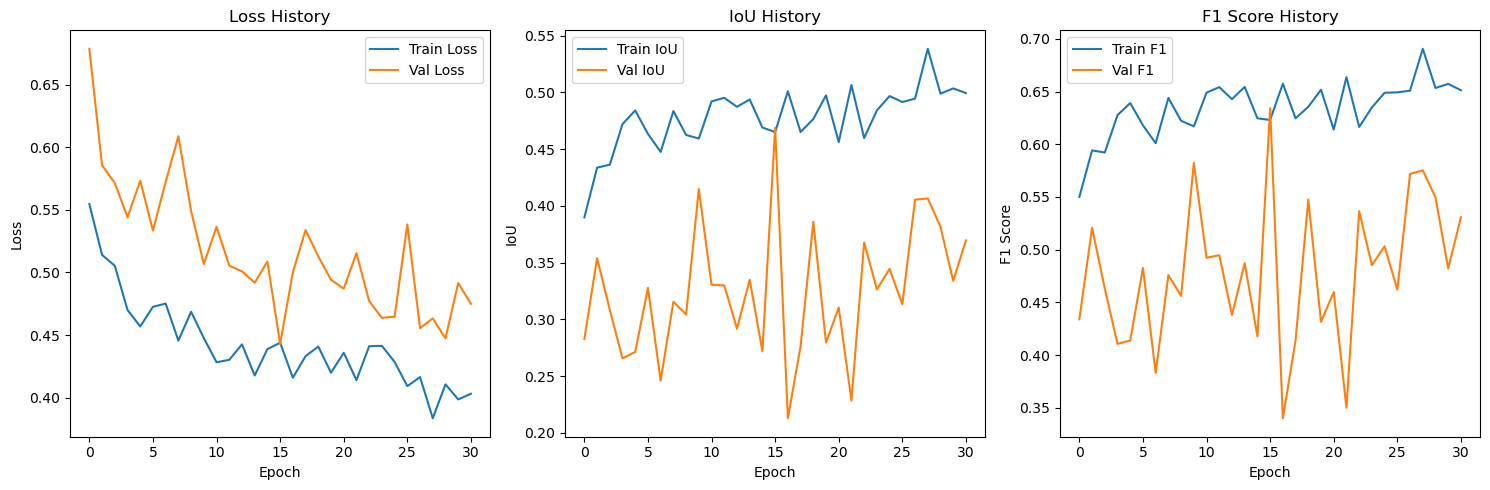

Training completed successfully!


In [7]:
def main():
    # Hyperparameters
    BATCH_SIZE = 8
    LEARNING_RATE = 5e-4
    NUM_EPOCHS = 200
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data paths
    zip_path = 'data-20250220T104951Z-001.zip'
    extract_path = './data'
    
    # Extract data
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    
    images_dir = os.path.join(extract_path, 'data', 'images')
    labels_dir = os.path.join(extract_path, 'data', 'labels')
    
    # Create dataset with transformations
    transform = AdvancedImageTransform(p=0.5)
    dataset = WaterSegmentationDataset(images_dir, labels_dir, transform=transform)
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Initialize model
    model = EnhancedAttentionUNet(in_channels=12, out_channels=1).to(device)
    
    # Loss function
    criterion = CombinedLoss()
    
    # Optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=5e-4,
        betas=(0.9, 0.999)
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=True
    )
    
    # Train model
    history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        NUM_EPOCHS, device
    )
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    train_iou = [metrics['IoU'] for metrics in history['train_metrics']]
    val_iou = [metrics['IoU'] for metrics in history['val_metrics']]
    plt.plot(train_iou, label='Train IoU')
    plt.plot(val_iou, label='Val IoU')
    plt.title('IoU History')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    train_f1 = [metrics['F1 Score'] for metrics in history['train_metrics']]
    val_f1 = [metrics['F1 Score'] for metrics in history['val_metrics']]
    plt.plot(train_f1, label='Train F1')
    plt.plot(val_f1, label='Val F1')
    plt.title('F1 Score History')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Save final model
    torch.save(model.state_dict(), 'final_model.pth')
    print("Training completed successfully!")

if __name__ == '__main__':
    main()